In [1]:
import os
import gc
import pandas as pd
import numpy as np
import transformers
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
import re
import string
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('df_full_clean.csv')

In [5]:
def build(transformer, maxlen=128):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_word_ids")
    cls_token = transformer(input_ids)[0][:,0,:]
    out = tf.reshape(cls_token, [-1, cls_token.shape[1], 1])
    out = Dropout(0.25)(out)
    out = Conv1D(100, 2, padding='valid', activation='relu', strides=1)(out)
    out = BatchNormalization(axis=2)(out)
    out = Conv1D(100, 3, padding='valid', activation='relu', strides=1)(out)
    out = BatchNormalization(axis=2)(out)
    out = Conv1D(100, 4, padding='valid', activation='relu', strides=1)(out)
    out = BatchNormalization(axis=2)(out)
    out = Conv1D(100, 5, padding='valid', activation='relu', strides=1)(out)
    out = BatchNormalization(axis=2)(out)
    out = GlobalMaxPooling1D()(out)
    out = Dropout(0.20)(out)
    out = Dense(1, activation='sigmoid')(out)
    model = Model(inputs=input_ids, outputs=out)
    model.compile(Adam(lr=1e-5), 
                  loss=BinaryCrossentropy(), metrics=['accuracy', AUC()])
    return model

In [8]:
df_train, df_test = train_test_split(df, train_size = 0.8, random_state=24)



In [9]:
X_train = df_train['question_text']
X_test = df_test['question_text']

In [10]:
y_train = df_train.target
y_test = df_test.target

In [13]:
print('Shape of Train Dataset',X_train.shape,y_train.shape)

Shape of Train Dataset (1044897,) (1044897,)


In [14]:
print('Shape of Test Dataset',X_test.shape, y_test.shape)

Shape of Test Dataset (261225,) (261225,)


In [15]:
# Global Variables
BATCHSIZE = 64
EPOCHS = 5


In [16]:
print(X_train)

224957     Is cyber security and hacking related to each ...
19865       Why should I play Star Wars : The Old Republic ?
720136                  What causes a gout in my pinky toe ?
111634     When will the laning and sidewalk construction...
1086939    What blogs would you recommend a WordPress new...
                                 ...                        
452753     What are some effective project management tip...
516439     What is the difference between fluoxetine and ...
1259712     What are the best features of QLOCKTWO WATCHES ?
899        What is the best motivation you have ever rece...
242082     Is it autism when some body praising himself a...
Name: question_text, Length: 1044897, dtype: object


In [17]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased')

I1104 05:46:34.612961 140237762742080 filelock.py:274] Lock 140233770491800 acquired on /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock


I1104 05:46:35.404067 140237762742080 filelock.py:318] Lock 140233770491800 released on /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391.lock


I1104 05:46:36.250780 140237762742080 filelock.py:274] Lock 140237667411224 acquired on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock


I1104 05:46:37.545982 140237762742080 filelock.py:318] Lock 140237667411224 released on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock


In [18]:
def encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        truncation=True
    )
    return np.array(enc_di['input_ids'])

In [19]:
x_train = encode(df_train.question_text.values, tokenizer, maxlen=100)
x_test = encode(df_test.question_text.values, tokenizer, maxlen=100)

In [20]:
print(x_train.shape)

(1044897, 100)


In [21]:
train_dataset = (
    tf.data.Dataset
        .from_tensor_slices((x_train, y_train))
        .repeat()
        .shuffle(x_train.shape[0])
        .batch(BATCHSIZE)

)

In [22]:

test_dataset = (
    tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(BATCHSIZE)
)

In [25]:
#with strategy.scope():
transformer_layer = transformers.TFAutoModel.from_pretrained('bert-base-uncased')
model = build(transformer_layer, maxlen=100)
model.summary()

I1104 05:55:12.037472 140237762742080 filelock.py:274] Lock 140233770175120 acquired on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock


I1104 05:55:12.834728 140237762742080 filelock.py:318] Lock 140233770175120 released on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock


I1104 05:55:13.912773 140237762742080 filelock.py:274] Lock 140233770175120 acquired on /root/.cache/torch/transformers/336363d3718f8cc6432db4a768a053f96a9eae064c8c96aff2bc69fe73929770.4733ec82e81d40e9cf5fd04556267d8958fb150e9339390fc64206b7e5a79c83.h5.lock


I1104 05:55:48.964624 140237762742080 filelock.py:318] Lock 140233770175120 released on /root/.cache/torch/transformers/336363d3718f8cc6432db4a768a053f96a9eae064c8c96aff2bc69fe73929770.4733ec82e81d40e9cf5fd04556267d8958fb150e9339390fc64206b7e5a79c83.h5.lock


Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 100, 768), (None, 109482240 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 768, 1)]          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 767, 100)          300       
_________________________________________________________________
batch_normalization (BatchNo (None, 767, 100)          400   

In [26]:
n_steps = 1024
training_history = model.fit(train_dataset, 
                             steps_per_epoch=n_steps,
                             epochs=5)

Epoch 1/5


W1104 05:56:33.789755 140237762742080 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss.
W1104 05:56:33.792238 140237762742080 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss.
W1104 05:56:41.026835 140237762742080 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss.
W1104 05:56:41.029077 140237762742080 optimizer_v2.py:1223] Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss.


1024/1024 [==============================] - 2337s 2s/step - loss: 0.4808 - accuracy: 0.8927 - auc: 0.6210
Epoch 2/5
1024/1024 [==============================] - 2333s 2s/step - loss: 0.3421 - accuracy: 0.9143 - auc: 0.7501
Epoch 3/5
1024/1024 [==============================] - 2331s 2s/step - loss: 0.2880 - accuracy: 0.9222 - auc: 0.7957
Epoch 4/5
1024/1024 [==============================] - 2331s 2s/step - loss: 0.2575 - accuracy: 0.9269 - auc: 0.8237
Epoch 5/5
1024/1024 [==============================] - 2331s 2s/step - loss: 0.2400 - accuracy: 0.9286 - auc: 0.8418


In [27]:
predict = model.predict(test_dataset)

In [28]:
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score

In [29]:
def line_search_f1_score(y_score, y_test):
    max_f1_score = 0
    opt_threshold = 0
    for threshold in [i*0.01 for i in range(100)]:
        y_preds = y_score > threshold
        score = f1_score(y_preds, y_test)
        if max_f1_score < score:
            max_f1_score = score
            opt_threshold = threshold
    return max_f1_score, opt_threshold

In [30]:
max_f1_score, threshold = line_search_f1_score(predict, y_test)

In [31]:
print('F1 score ',max_f1_score)

F1 score  0.5738301891958493


In [32]:
predict2 = [1 if x >= threshold else 0 for x in predict]

In [33]:
confusion_matrix(y_test, predict2)

array([[235181,   9856],
       [  5709,  10479]])

In [34]:
cf_matrix = confusion_matrix(predict2, y_test)

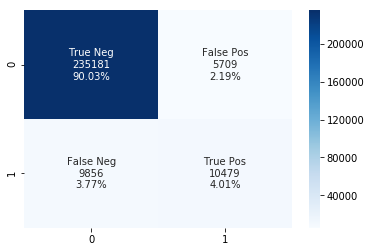

In [35]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [36]:
import sklearn.metrics as metrics
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, predict)
roc_auc = metrics.auc(fpr, tpr)

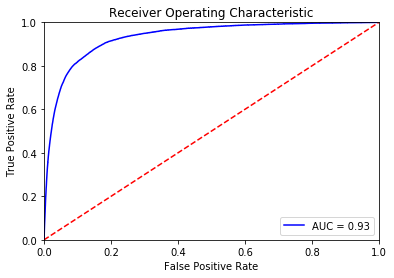

In [37]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



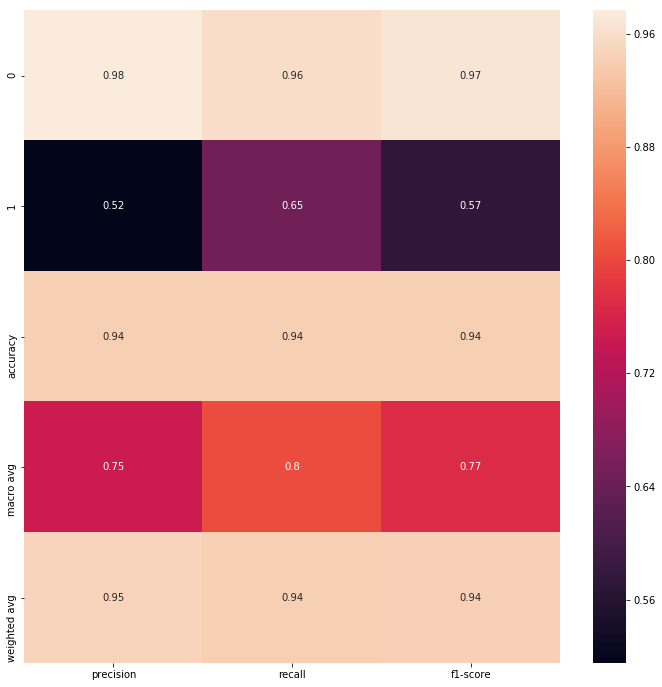

In [38]:
from sklearn.metrics import classification_report

clf_report = classification_report(y_test,
                                   predict2,
                                   labels=[0,1],
                                   output_dict=True)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax,square = False)